In [2]:
!nvidia-smi #show the allocated GPU

Sun Apr 11 13:08:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Connect your Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, shutil
base_dir = 'drive/My Drive/covidvsnoncovid'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(512, 512),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        color_mode="grayscale")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary',
        color_mode="grayscale")

Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
from keras.applications import VGG16
from keras.layers import Concatenate
from keras.layers import Dropout, Flatten, Dense,Input
img_size_target = 512
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_tensor=img_conc)

In [7]:
conv_base.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

In [8]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 48,269,633
Trainable params: 48,269,633
Non-trainable params: 0
_________________________________________________________________


In [10]:
for layer in conv_base.layers : 
  print(layer.name , '==>' , layer.trainable)

input_1 ==> True
concatenate ==> True
block1_conv1 ==> True
block1_conv2 ==> True
block1_pool ==> True
block2_conv1 ==> True
block2_conv2 ==> True
block2_pool ==> True
block3_conv1 ==> True
block3_conv2 ==> True
block3_conv3 ==> True
block3_pool ==> True
block4_conv1 ==> True
block4_conv2 ==> True
block4_conv3 ==> True
block4_pool ==> True
block5_conv1 ==> True
block5_conv2 ==> True
block5_conv3 ==> True
block5_pool ==> True


In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
for layer in conv_base.layers : 
  print(layer.name , '==>' , layer.trainable)

input_1 ==> False
concatenate ==> False
block1_conv1 ==> False
block1_conv2 ==> False
block1_pool ==> False
block2_conv1 ==> False
block2_conv2 ==> False
block2_pool ==> False
block3_conv1 ==> False
block3_conv2 ==> False
block3_conv3 ==> False
block3_pool ==> False
block4_conv1 ==> False
block4_conv2 ==> False
block4_conv3 ==> False
block4_pool ==> False
block5_conv1 ==> True
block5_conv2 ==> True
block5_conv3 ==> True
block5_pool ==> True


In [13]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 1422s 14s/step - loss: 0.5497 - acc: 0.7520 - val_loss: 0.9402 - val_acc: 0.7930
Epoch 2/20
100/100 [==============================] - 957s 10s/step - loss: 0.3157 - acc: 0.8785 - val_loss: 0.9287 - val_acc: 0.7920
Epoch 3/20
100/100 [==============================] - 710s 7s/step - loss: 0.2636 - acc: 0.9036 - val_loss: 1.5062 - val_acc: 0.7800
Epoch 4/20
100/100 [==============================] - 529s 5s/step - loss: 0.2739 - acc: 0.9001 - val_loss: 1.0980 - val_acc: 0.7970
Epoch 5/20
100/100 [==============================] - 432s 4s/step - loss: 0.2605 - acc: 0.9010 - val_loss: 1.4044 - val_acc: 0.7930
Epoch 6/20
100/100 [==============================] - 353s 4s/step - loss: 0.2376 - acc: 0.9115 - val_loss: 2.2845 - val_acc: 0.7400
Epoch 7/20
100/100 [==============================] - 305s 3s/step - loss: 0.2563 - acc: 0.9020 - val_loss: 1.6072 - val_acc: 0.7910
Epoch 8/20
100/100 [==============================] - 267s 3s/step

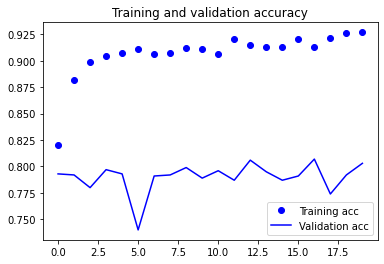

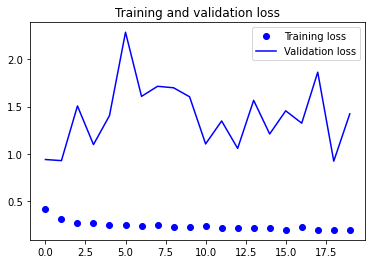

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()